# Diabetes Prediction

This project analyzes a dataset from kaggle about Diabetes prediction. The dataset I'm using is (Mustafa, 2023). It contains information about patients and their diabetes status.

The goal of the project is to determine if a person has diabetes using medical information available about the person. It uses Logistic regression since this is a binary classification problem. It performs EDA, trains the models, and then evaluates them.

The dataset used here has 100,000 entries and here are the columns:

- `gender`: The gender of the patient.


- `age`: The age of the patient.


- `hypertension`: Whether the patient has hypertension.


- `heart_disease`: Wheather the patient has heart disease.


- `smoking_history`: The smoking history of the patient.


- `bmi`: The patient's body mass index.


- `HbA1c_level`: The Hemoglobin A1c level of the patient.


- `blood_glucose_level`: The blood glucose level of the patient.


- `diabetes`: The target variable. Whether the patient is diabetic.



In [1]:
%matplotlib inline
import numpy as np
#import scipy as sp
#import scipy.stats as stats
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import statsmodels.api as sm

from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, log_loss,
                            roc_curve, roc_auc_score)

## Exploratory Data Analysis

Let's load the dataset into pandas and see the what the fields are like.

In [2]:
df = pd.read_csv("data/diabetes_prediction_dataset.csv") 
print(df.info())
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None
                 age  hypertension  heart_disease            bmi   
count  100000.000000  100000.00000  100000.000000  100000.000000  \
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.6

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


As you can see, there are 100,000 rows and no null columns in any of them.

The fields `age`,`bmi`,`HbA1c_level`, and `blood_glucose_level` are continuous.

The fields `hypertension`,`heart_disease`, and `diabetes` are discrete and binary. `diabetes` will be our target variable.

The fields `gender` and `smoking_history`, however, are categorical. Let us see if they can be converted to discrete or continuous data.

### Transformations

Let's start by printing out the possible values `gender` and `smoking_history` can take.

In [110]:
print(df.smoking_history.unique())
print(df.gender.unique())

['never' 'No Info' 'current' 'former' 'ever' 'not current']
['Female' 'Male' 'Other']


We can see here that even though there are no null values for smoking history, "No Info" is the same as having a missing value. Let's see how many such cases there are. While we're doing that, we'll also print out how many cases of each listed gender there are.

In [111]:
print(df['smoking_history'].value_counts())
print(df['gender'].value_counts())

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64
gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64


As you can see, there are only 18 cases where the gender is listed as "Other". Gender isn't known to be a major factor in determining whether a patient has diabetes, but men are statistically more likely to get type 2 diabetes (Kautzky-Willer et al., 2016). One known reason is that men store more fat in the abdomen area, which is a known risk factor. We can add a binary flag for whether the gender is "Male" as a new column.

Smoking, on the other hand, is known to be one of the causes of type 2 diabetes. People who smoke are 30-40% more likely to develop type 2 diabetes (Maddatu et al., 2017). This gives us a good reason to have it in the model, but we'll have to find a way to quantify it. For now, we'll transform it into an ordinal variable and save it in a new column. Then we'll copy the data to a new dataset and remove any rows with missing entries for the smoking history.

In [112]:
# Flag for whether a person is male
df['male'] = np.where(df['gender']== 'Male', 1, 0)

# Transform smoking history to ordinal data
df['smoking_ordinal'] = 0
df['smoking_ordinal'] = np.where(df['smoking_history']== 'ever', 1, df['smoking_ordinal'])
df['smoking_ordinal'] = np.where(df['smoking_history']== 'former', 2, df['smoking_ordinal'])
df['smoking_ordinal'] = np.where(df['smoking_history']== 'not current', 3, df['smoking_ordinal'])
df['smoking_ordinal'] = np.where(df['smoking_history']== 'current', 4, df['smoking_ordinal'])

# Remove the rows where smoking history is missing
df_transformed = df[df.smoking_history != 'No Info']

df_transformed.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,male,smoking_ordinal
0,Female,80.0,0,1,never,25.19,6.6,140,0,0,0
2,Male,28.0,0,0,never,27.32,5.7,158,0,1,0
3,Female,36.0,0,0,current,23.45,5.0,155,0,0,4
4,Male,76.0,1,1,current,20.14,4.8,155,0,1,4
5,Female,20.0,0,0,never,27.32,6.6,85,0,0,0


### Feature Selection

Finally, let's drop the categorical entries and generate a correlation matrix to see which features are corellated to diabetes. This will also help us check for collinearity between features better.

<Axes: >

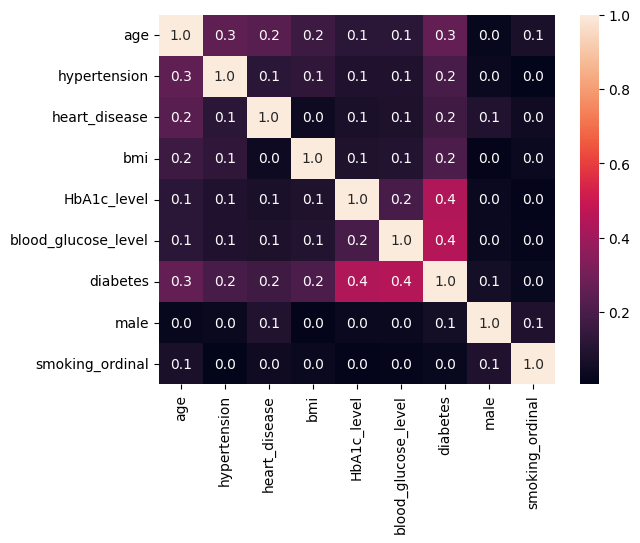

In [104]:
df_transformed = df_transformed.drop(columns=['gender', 'smoking_history'])
df_transformed.head()
sns.heatmap(df_transformed.corr(), annot=True, fmt=".1f")

As suspected, gender seems to have very little corellation with diabetes. We can still keep in in the model since it might give us more accurate results. It also doesn't seem very corellated to the other features.

Our ordinal transformation for the smoking history seems to have no linear corellation with diabetes. This could be for many reasons. Perhaps our transformation isn't suitable for such a variable. Unfortunately, we don't have more specific data for the smoking history. It might be a good idea to leave it out of our model.

All of the other features do have some correlation to our target variable, so we can keep them.

Since we are not using smoking history in our model, we can use the original model which contains all the rows.

<Axes: >

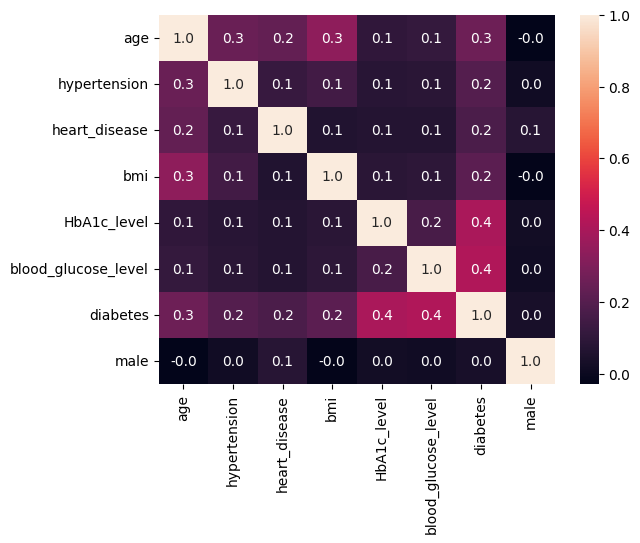

In [105]:
# Use original dataset with all rows
df = df.drop(columns=['gender', 'smoking_history','smoking_ordinal'])
sns.heatmap(df.corr(), annot=True, fmt=".1f")

We can see some correlation between multiple features. The HbA1c level and blood glucose level are both strongly related to diabetes, but they are also correlated to each other. This makes sense because the HbA1c level is the Hemoglobin A1c level which measures the Glycosylation of haemoglobin. It's a test for measuring  average blood glucose levels for the last two to three months. The blood glucose level features measures the blood glucose levels at the time of testing.

It might seem counterintuitive to have both of these features and we run the risk of overfitting the model. We can train 3 models and see which one performs better. One would have both the features and the other two would have one each.

Age seems to be correlated to multiple features. This makes sense since people who are older are more likely to have hypertension or heart disease. Let us look at a pairplot to get a better understanding.

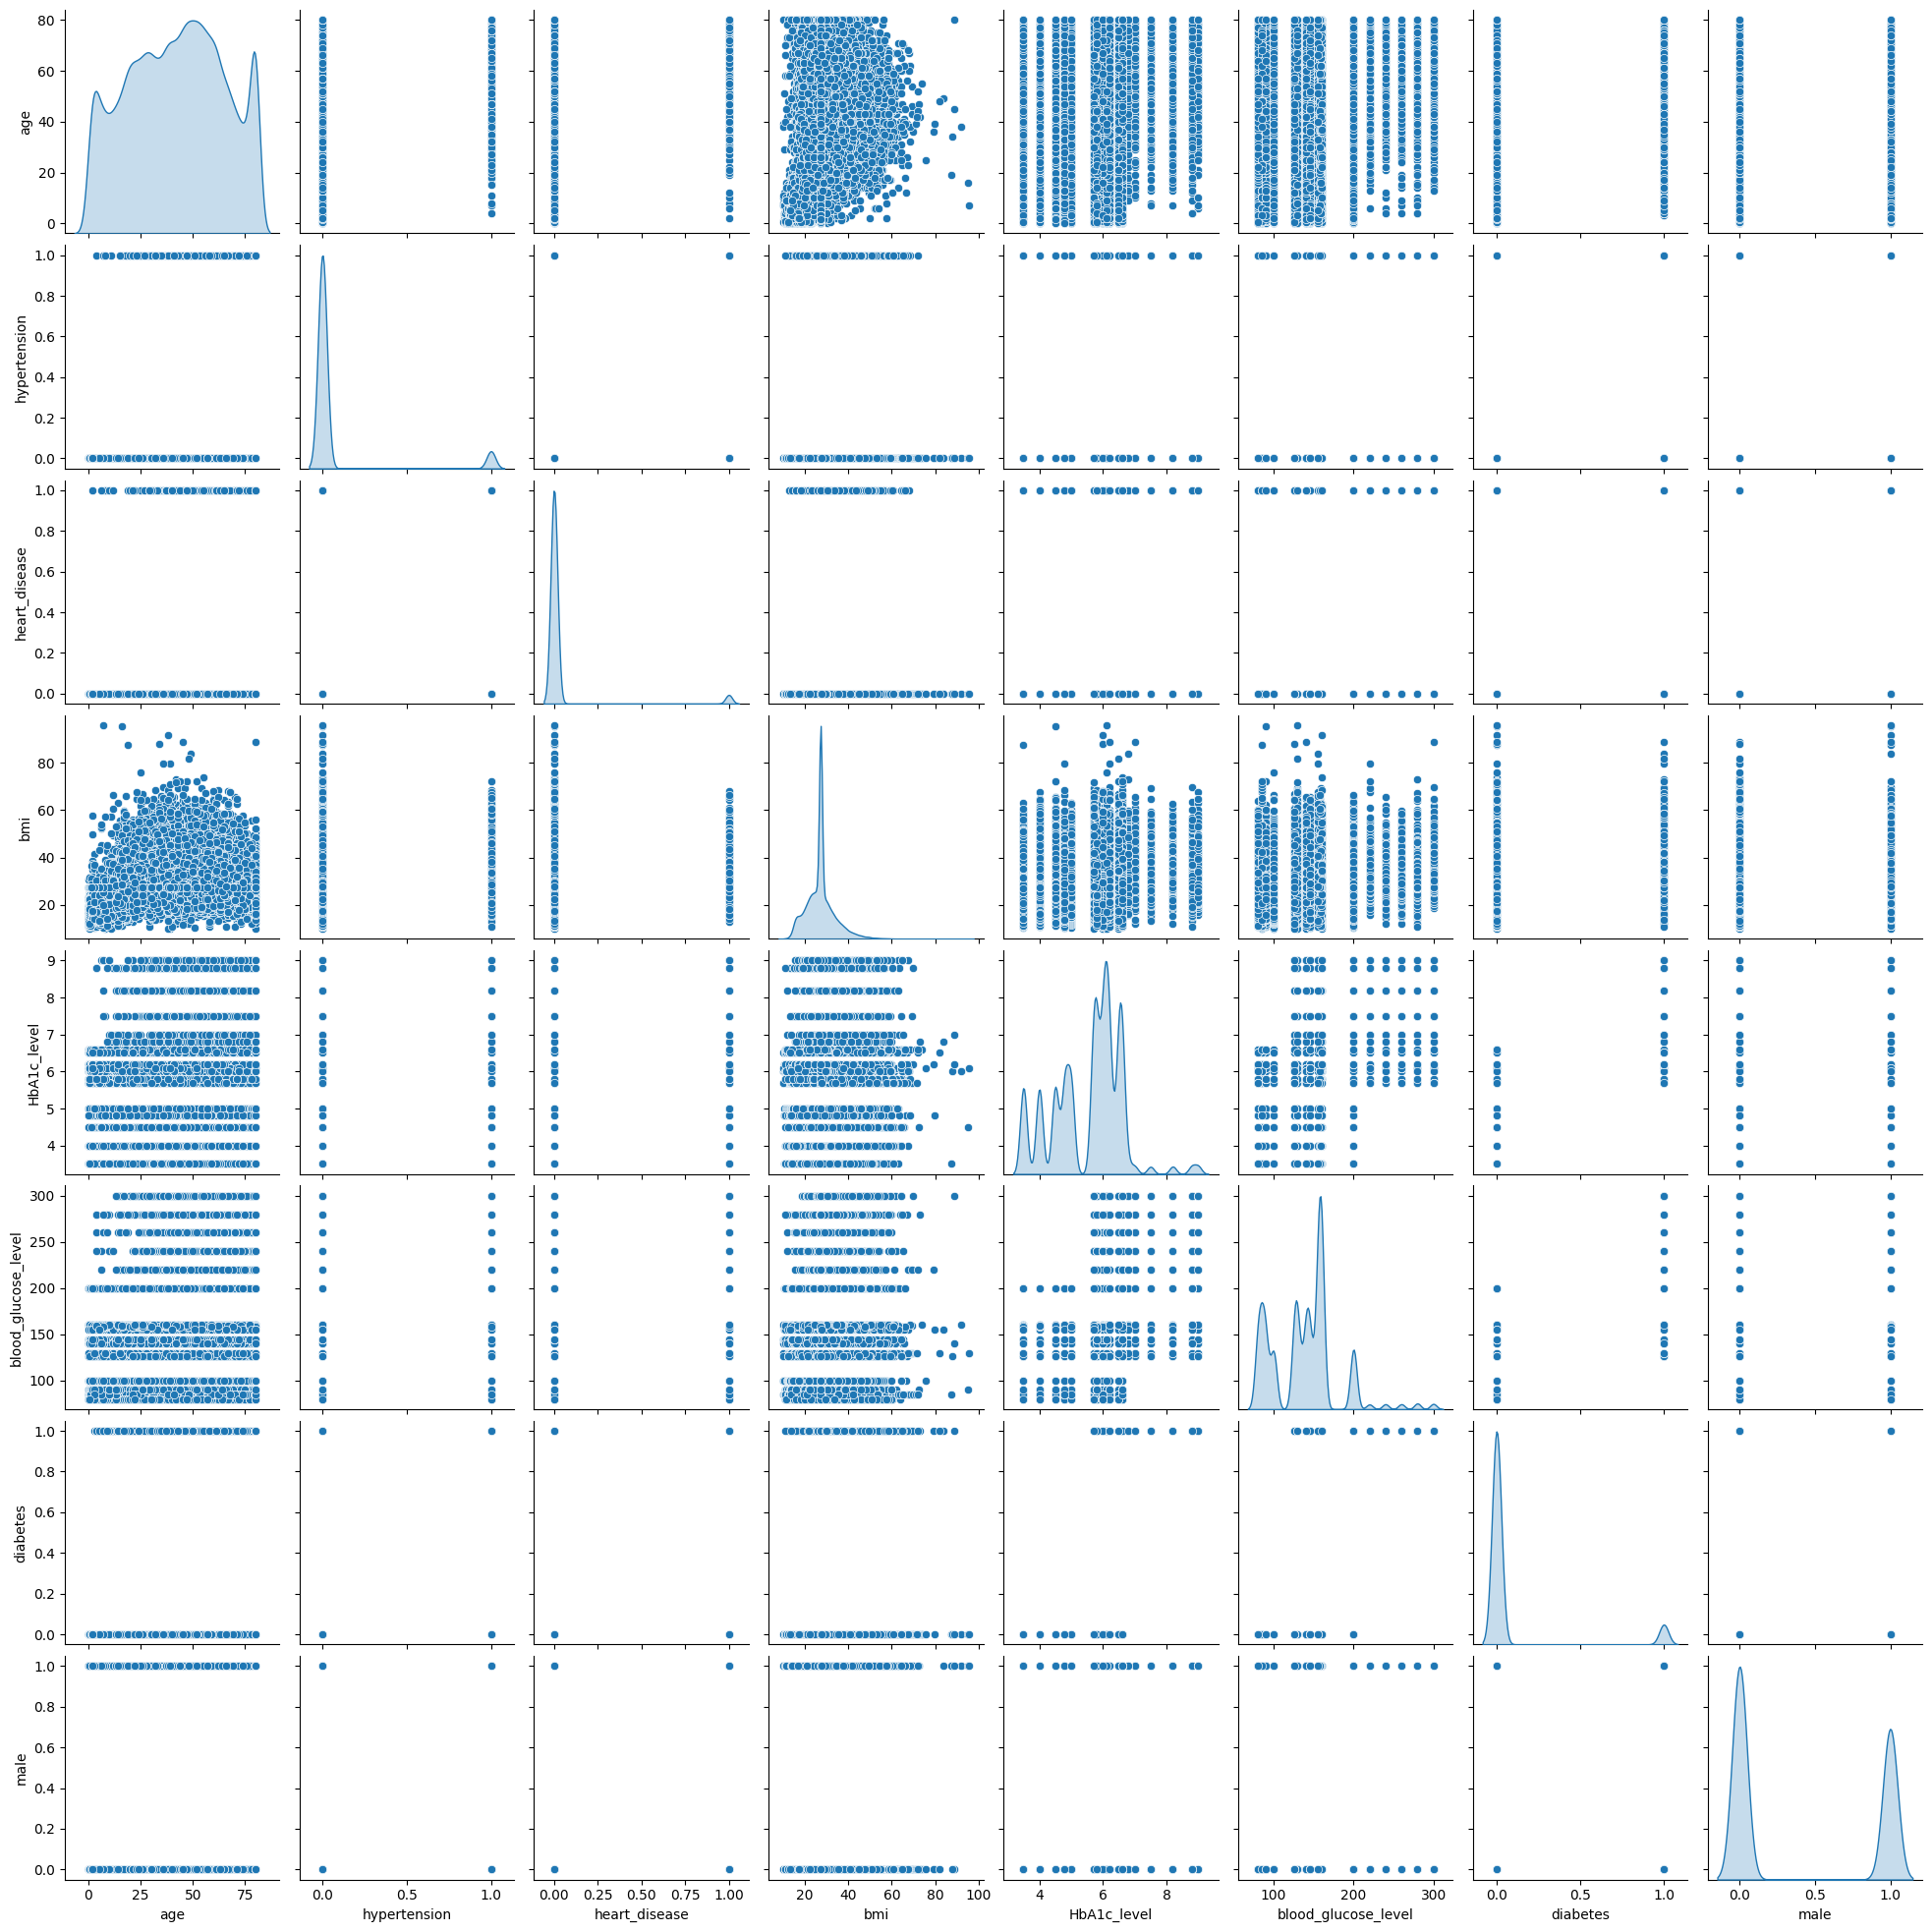

In [81]:
sns.pairplot(df,diag_kind='kde')

These plots suggest that people of all ages can have hypertension and the same is true for heart disease. BMI seems to vary regardless of the age too. We can keep age in the model since we don't see a linear relationship between them.

We do se some kind of structure between HbA1c level and blood glucose level. It's a good thing we're testing models with one of those features too.

## Models

Let's start by splitting the model into test and training data. Note that I'm using 20% of the original dataset as test data. Since this would have 20,000 rows, we have a lot of data to test with.

In [106]:
df_train, df_test = train_test_split(df, test_size = 0.2, shuffle=False)

I will be using the test data to check the metrics, to know I'm not overfitting the model.

### Logit Model

The first model I'm testing with is the Logit model. This was covered in Week 3 of the course in Logistic Regression.

As a reminder, the Logit model uses the following formula to calculate the probability.

$P(Y=1∣X)=\frac{1}{1+e^{-z}}$

In [87]:
log_reg = smf.logit('diabetes ~ age + hypertension + heart_disease + bmi'
                    ' + HbA1c_level + blood_glucose_level + male', data=df_train).fit(disp=0)
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               diabetes   No. Observations:                80000
Model:                          Logit   Df Residuals:                    79992
Method:                           MLE   Df Model:                            7
Date:                Mon, 01 May 2023   Pseudo R-squ.:                  0.6077
Time:                        17:46:22   Log-Likelihood:                -9148.8
converged:                       True   LL-Null:                       -23322.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -27.4994      0.323    -85.044      0.000     -28.133     -26.866
age                     0.0456      0.001     37.809      0.000       0.043       0.048
hypertension            0.7880      0.053     14.984      0.000       0.685       0.891
heart_disease           0.7980      0.068     11.814      0.000       0.666       0.930
bmi                     0.0919      0.003     32.422      0.000       0.086       0.097
HbA1c_level             2.3599      0.040     58.965      0.000       2.281       2.438
blood_glucose_level     0.0332      0.001     62.166      0.000       0.032       0.034
male                    0.2721      0.040      6.829      0.000       0.194       0.350
=======================================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

The p-values for the coefficients suggest that all of the features are statistically significant.

Let us now check if the score is any better if we leave out the HbA1c level or blood glucose level.

In [69]:
log_pred = np.round(log_reg.predict(df_test))

# With HbA1c_level but without blood_glucose_level
log_hba1c = smf.logit('diabetes ~ age + hypertension + heart_disease + bmi'
                      ' + HbA1c_level + male', data=df_train).fit(disp=0)
log_hba1c_pred = np.round(log_hba1c.predict(df_test))

# With blood_glucose_level but without HbA1c_level
log_glucose = smf.logit('diabetes ~ age + hypertension + heart_disease + bmi'
                      ' + blood_glucose_level + male', data=df_train).fit(disp=0)
log_glucose_pred = np.round(log_glucose.predict(df_test))

# Testing the accuracy of all 3 models
print('Accuracy with both HbA1c_level and blood_glucose_level:', accuracy_score(df_test['diabetes'], log_pred))
print('Accuracy without blood_glucose_level:', accuracy_score(df_test['diabetes'], log_hba1c_pred))
print('Accuracy without HbA1c_level:', accuracy_score(df_test['diabetes'], log_glucose_pred))

Accuracy with both HbA1c_level and blood_glucose_level: 0.95965
Accuracy without blood_glucose_level: 0.9448
Accuracy without HbA1c_level: 0.9424


The accuracy score seems to suggest that using both the predictors gives us the best performance.

### Probit Model

Here's a model not covered in the course. The Probit model is very similar to the Logit model but uses the following formula to calculate the probability.

$P(Y=1∣X)=\phi(z)$ where $\phi$ is the standard normal distribution.

Probit is useful if the residual terms are normally distributed. This is a reasonable assumption to make since the residuals in a well-fitted model center around the regression line. A Probit model accounts for normality when fitting the model to the training data.

In [72]:
prob_reg = smf.probit('diabetes ~ age + hypertension + heart_disease + bmi'
                      ' + HbA1c_level + blood_glucose_level + male', data=df_train).fit(disp=0)
prob_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:               diabetes   No. Observations:                80000
Model:                         Probit   Df Residuals:                    79992
Method:                           MLE   Df Model:                            7
Date:                Mon, 01 May 2023   Pseudo R-squ.:                  0.6055
Time:                        16:50:14   Log-Likelihood:                -9201.4
converged:                       True   LL-Null:                       -23322.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -14.3941      0.157    -91.524      0.000     -14.702     -14.086
age                     0.0235      0.001     38.869      0.000       0.022       0.025
hypertension            0.4252      0.028     15.025      0.000       0.370       0.481
heart_disease           0.4379      0.037     11.942      0.000       0.366       0.510
bmi                     0.0479      0.001     32.402      0.000       0.045       0.051
HbA1c_level             1.2241      0.020     61.282      0.000       1.185       1.263
blood_glucose_level     0.0177      0.000     63.721      0.000       0.017       0.018
male                    0.1428      0.021      6.922      0.000       0.102       0.183
=======================================================================================

Possibly complete quasi-separation: A fraction 0.31 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

These p-values also suggest that all of the features are statistically significant.

In [74]:
prob_pred = np.round(prob_reg.predict(df_test))

# With HbA1c_level but without blood_glucose_level
prob_hba1c = smf.probit('diabetes ~ age + hypertension + heart_disease + bmi'
                      ' + HbA1c_level + male', data=df_train).fit(disp=0)
prob_hba1c_pred = np.round(prob_hba1c.predict(df_test))

# With blood_glucose_level but without HbA1c_level
prob_glucose = smf.probit('diabetes ~ age + hypertension + heart_disease + bmi'
                      ' + blood_glucose_level + male', data=df_train).fit(disp=0)
prob_glucose_pred = np.round(prob_glucose.predict(df_test))

# Testing the accuracy of all 3 models
print('Accuracy with both HbA1c_level and blood_glucose_level:', accuracy_score(df_test['diabetes'], prob_pred))
print('Accuracy without blood_glucose_level:', accuracy_score(df_test['diabetes'], prob_hba1c_pred))
print('Accuracy without HbA1c_level:', accuracy_score(df_test['diabetes'], prob_glucose_pred))

Accuracy with both HbA1c_level and blood_glucose_level: 0.96
Accuracy without blood_glucose_level: 0.9448
Accuracy without HbA1c_level: 0.94325


Just like with the Logit model, using both the predictors gives us the best performance.

## Results and Analysis

### Logit Model

Let's evaluate the Logit model by calculating some performance metrix, starting with the confusion matrix

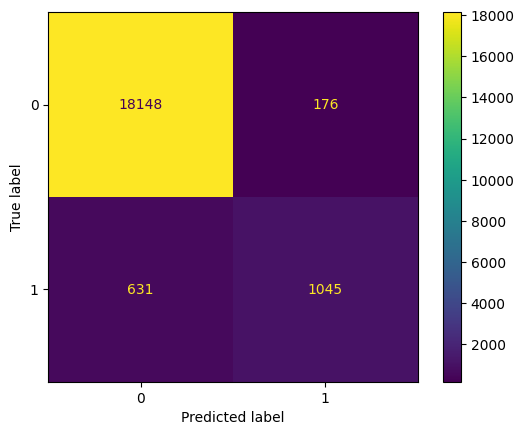

In [98]:
log_conf_matrix = confusion_matrix(df_test['diabetes'],log_pred)
log_disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=log_conf_matrix)
log_disp.plot()

Here are some more performance metrics that would help us evaluate the model

In [91]:
print("Accuracy Score:", accuracy_score(df_test['diabetes'], log_pred))
print("Precision Score:", precision_score(df_test['diabetes'], log_pred))
print("Recall Score:", recall_score(df_test['diabetes'], log_pred))
print("F1 Score:", f1_score(df_test['diabetes'], log_pred))
print("Cross-Entropy Loss:", log_loss(df_test['diabetes'], log_reg.predict(df_test)))

Accuracy Score: 0.95965
Precision Score: 0.8558558558558559
Recall Score: 0.6235083532219571
F1 Score: 0.72143596824301
Cross-Entropy Loss: 0.113520970456436


Finally, let's generate the ROC curve for the model.

Text(0.7, 0.2, 'AUC=0.962')

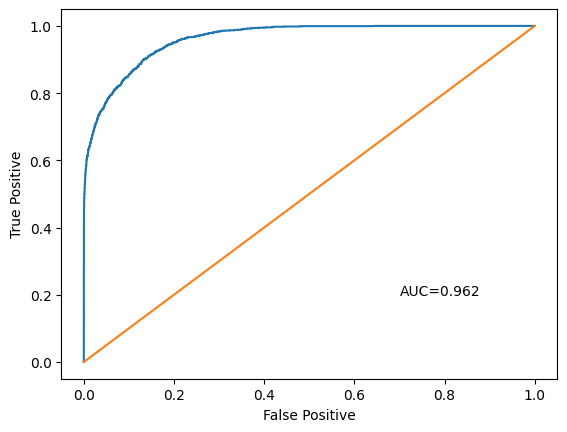

In [92]:
fpr, tpr, th = roc_curve(df_test['diabetes'], log_reg.predict(df_test))
auc = roc_auc_score(df_test['diabetes'], log_reg.predict(df_test))
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.text(0.7,0.2,'AUC='+'{:.3f}'.format(auc))

### Probit Model

Here are same performance metrix for the Probit model.

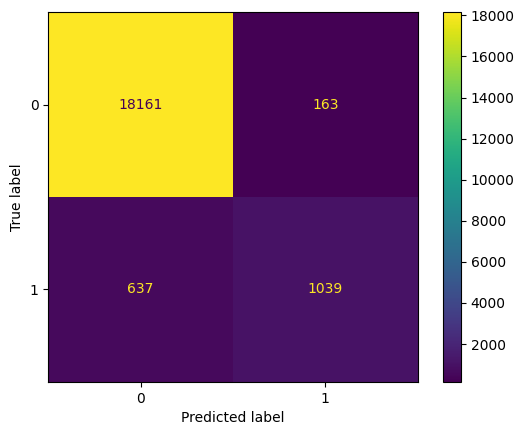

In [93]:
prob_conf_matrix = confusion_matrix(df_test['diabetes'],prob_pred)
prob_disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=prob_conf_matrix)
prob_disp.plot()

In [94]:
print("Accuracy Score", accuracy_score(df_test['diabetes'], prob_pred))
print("Precision Score", precision_score(df_test['diabetes'], prob_pred))
print("Recall Score", recall_score(df_test['diabetes'], prob_pred))
print("F1 Score", f1_score(df_test['diabetes'], prob_pred))
print("Cross-Entropy Loss", log_loss(df_test['diabetes'], prob_reg.predict(df_test)))

Accuracy Score 0.96
Precision Score 0.8643926788685524
Recall Score 0.619928400954654
F1 Score 0.7220291869353718
Cross-Entropy Loss 0.11378138625687056


Text(0.7, 0.2, 'AUC=0.962')

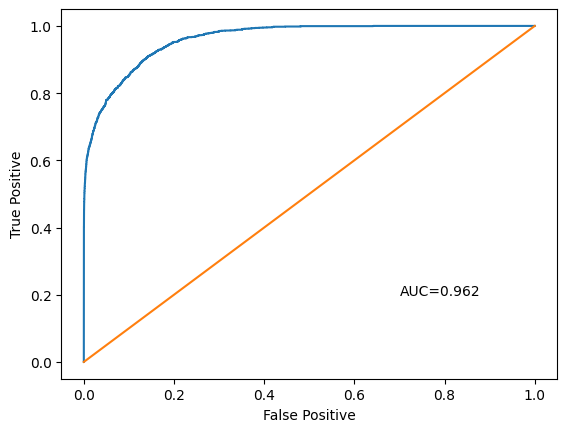

In [95]:
fpr, tpr, th = roc_curve(df_test['diabetes'], prob_reg.predict(df_test))
auc = roc_auc_score(df_test['diabetes'], prob_reg.predict(df_test))
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.text(0.7,0.2,'AUC='+'{:.3f}'.format(auc))

### Comparison

Here is a comparison of each metric for both models, with the better score in bold. Note that for Cross_Entropy, a lower number is a better score. I also made bold the names of the metrics I consider more important.

| Metric | Logit | Probit |
| --- | --- | --- |
| Accuracy Score | 0.95965 | **0.96** |
| Precision Score | 0.8558558558558559 | **0.8643926788685524** |
| Recall Score | **0.6235083532219571** | 0.619928400954654 |
| **F1 Score** | 0.72143596824301 | **0.7220291869353718** |
| **Cross-Entropy Loss** | **0.113520970456436** | 0.11378138625687056 |
| **AUC** | 0.962 | 0.962 |

While precision and recall are both important, the F1 score actually considers both of them and can tell you based on both scores which one you should consider. Based on this metric, the Probit model seems to be better.

However, the Cross-Entropy Loss function tells us that Logit is a better model. I prefer this metric over accuracy since it takes into account the actual probability rather than just the labels. The ROC/AUC seems to be the same for both.

## Discussion

Based on multiple metrics, the two models I chose seem to have similar performance. If I had to choose between one of them, I would go with the Logit model since it has an easier interpretation and gives stronger probability predictions for this dataset.

Unfortunately, the kind of information I had for smoking history wasn't sufficient enough to justify adding it to the model. It would have been more useful if I had a continuous variable that tells us how frequently or how recently a person smoked.

The model can be improved if the target was a continuous variable. In that case, a linear regression model can be used to determine how severe a person's diabetes is.

## References
- Mustafa, M. (2023, April 8). Diabetes prediction dataset. Kaggle. Retrieved May 1, 2023, from https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset 
- Kautzky-Willer, A., Harreiter, J., & Pacini, G. (2016). Sex and Gender Differences in Risk, Pathophysiology and Complications of Type 2 Diabetes Mellitus. Endocrine Reviews, 37(3), 278–316. https://doi.org/10.1210/er.2015-1137
- Maddatu, J., Anderson-Baucum, E., & Evans-Molina, C. (2017). Smoking and the risk of type 2 diabetes. Translational Research, 184, 101–107. https://doi.org/10.1016/j.trsl.2017.02.004